# Project 2

# Week 7 | Project - 2
Group 4: Joshua Hummell, Jiho Kim, Scott Reed



1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

## Data load

The first thing we want to do is load the packages and data. The data is from a Facebook-like Forum Network we: [https://toreopsahl.com/datasets/#online_forum_network](https://toreopsahl.com/datasets/#online_forum_network). The data represents an two-mode network among 899 users and 522 topics. The connections are weighted the number of messages or characters that a user posted about a topic.


In [67]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
import pandas as pd
import scipy
import random

Now let's take a look at what we will be working with

In [26]:
SN_Data = pd.read_csv("https://raw.githubusercontent.com/jhumms/620/main/project-2/social_network_data.csv")
SN_Data['user'] = 'u' + SN_Data['user'].astype(str)
SN_Data['topic'] = 'p' + SN_Data['topic'].astype(str)
SN_Data.head()

,user,topic,weight
0,u1,p1,1
1,u1,p39,9
2,u1,p102,2
3,u1,p154,1
4,u1,p357,5


In [27]:
## Creating the Network
G = nx.Graph()
G.add_nodes_from(SN_Data['user'], bipartite=0)
G.add_nodes_from(SN_Data['topic'], bipartite=1)
G.add_weighted_edges_from([d for d in SN_Data[['user','topic','weight']].values])

In [28]:
nx.is_connected(G)

False

In [29]:
bi.is_bipartite(G)

True

Blue for Users | Red for Pages


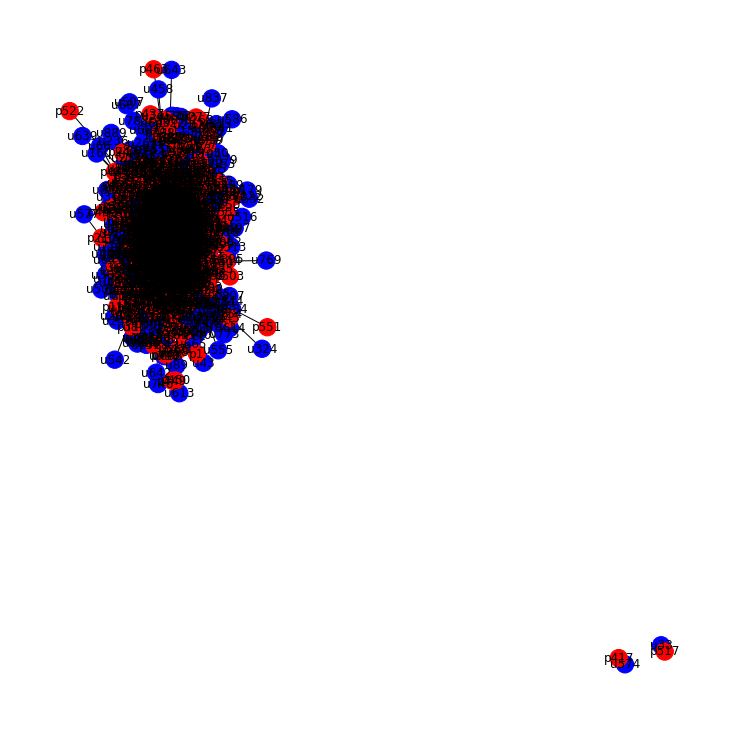

In [86]:
plt.figure(figsize=(10,10))
print("Blue for Users | Red for Pages")
colors = ["blue" if i in user_nodes  else "red" for i in G.nodes]
pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

In [32]:
print("It has Nodes:",len(G.nodes), " and Edges:",len(G.edges))

It has Nodes: 1421  and Edges: 7089


In [33]:
print("The Density is:", round(nx.density(G),4))

The Density is: 0.007


In [35]:
print("Are they all connected?",nx.is_connected(G))

Are they all connected? False


In [36]:
# Nodes
user_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
page_nodes = set(G) - user_nodes

In [37]:
bi.is_bipartite(G)

True

In [38]:
print("The User Nodes density is:",round(bi.density(G, user_nodes),4))

The User Nodes density is: 0.0151


In [39]:
print("The User Page density is:",round(bi.density(G, page_nodes),4))

The User Page density is: 0.0151


Now let's get the Degree Centrality as well as some other measures.

In [40]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[0:10]

[('p10', 126),
 ('p13', 117),
 ('u67', 99),
 ('p82', 96),
 ('p12', 92),
 ('u100', 88),
 ('u164', 84),
 ('p59', 82),
 ('p75', 82),
 ('p91', 79)]

In [41]:
#closeness
closeness = nx.closeness_centrality(G)
sorted(closeness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.3803909664885867),
 ('p13', 0.3770390567705297),
 ('u67', 0.37693840566087394),
 ('p10', 0.3710936314338065),
 ('u290', 0.3696364574883858)]

In [42]:
#betweenness
betweenness = nx.betweenness_centrality(G)
sorted(betweenness.items(), key=lambda x: x[1], reverse = True)[:5]

[('p10', 0.06320763139922769),
 ('p13', 0.06161931665609316),
 ('u67', 0.0560992693991688),
 ('u100', 0.04718668545540714),
 ('p82', 0.04472001062982433)]

In [43]:
#pagerank
pagerank = nx.pagerank(G)
sorted(pagerank.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.01842003173143345),
 ('p82', 0.010681111172635711),
 ('u67', 0.010061151430456248),
 ('p13', 0.009371136768806894),
 ('p59', 0.008654844629259141)]

We can see that there are several common users and pages

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

Let's take a look at the number of connections:

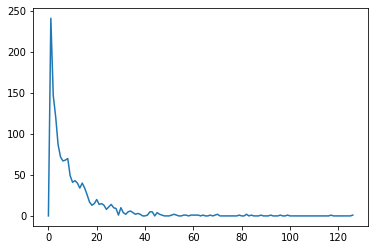

In [45]:
plt.plot(nx.degree_histogram(G))

It looks like the best place for islands will be after 60

In [58]:
def trim_edges(g, weight=1):
    g2=nx.Graph()  
    my_list=[]
    my_list1=[]
    for f, to, edata in g.edges(data=True): 
        if edata['weight'] > weight:
            my_list.append(f)
            my_list1.append(to)
            g2.add_edge(f,to,attr_dict={weight:edata['weight']})
    g2.add_nodes_from(my_list, bipartite=0)
    g2.add_nodes_from(my_list1, bipartite=1)
    return g2

In [59]:
def island_method(g, iterations=5, weight=1):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    mn=int(min(weights)) if int(min(weights)) > weight else weight
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/(iterations-1))
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]


In [78]:
# Running function for 5 iterations and a minimum weight of 5
islands = island_method(G, 5,5)
for i in islands:
    threshold = i[0]
    graph_size = len(i[1])
    connected_comp = len(list(G.subgraph(c) for c in nx.connected_components(i[1])))
    print("Weight: " + str(threshold), "Nodes: " + str(graph_size), "Subgraphs: " + str(connected_comp)
          )

Weight: 5 Nodes: 681 Subgraphs: 5
Weight: 46 Nodes: 41 Subgraphs: 7
Weight: 87 Nodes: 11 Subgraphs: 5
Weight: 128 Nodes: 4 Subgraphs: 2
Weight: 169 Nodes: 2 Subgraphs: 1


Now lets take a look at the 2nd 3rd and 4th largest graphs

Blue for Users | Red for Pages


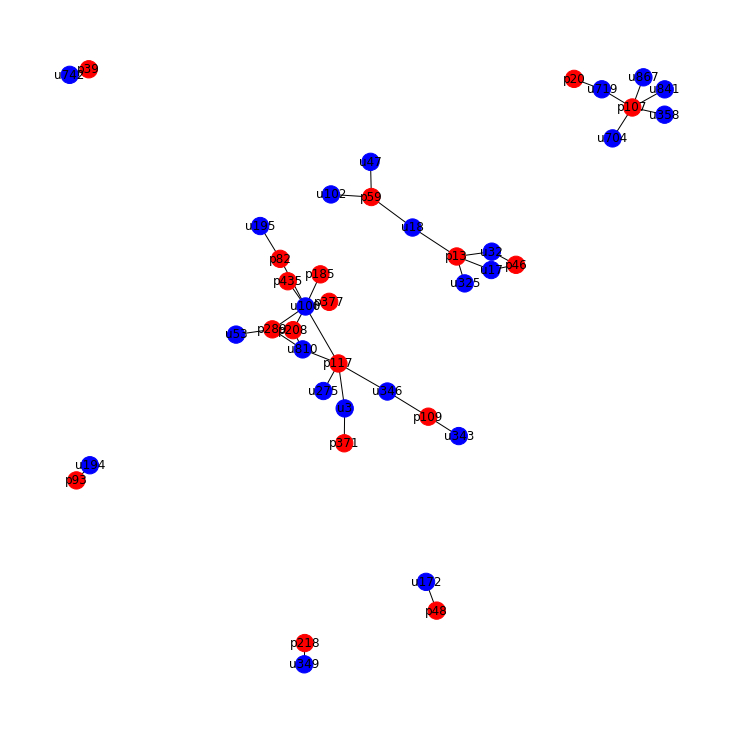

In [85]:
G1=islands[1][1]

plt.figure(figsize=(10,10))
print("Blue for Users | Red for Pages")
colors = ["blue" if i in user_nodes  else "red" for i in G1.nodes]
pos = nx.spring_layout(G1, seed=648)  # Seed layout for reproducible node positions
nx.draw(G1, pos, with_labels=True, node_color=colors)
plt.show()

In [87]:
sorted(G1.degree, key=lambda x: x[1], reverse=True)[0:10]

[('u100', 7),
 ('p117', 5),
 ('p107', 5),
 ('p13', 4),
 ('p59', 3),
 ('p289', 3),
 ('u810', 3),
 ('u3', 2),
 ('u17', 2),
 ('p46', 2)]

In [88]:
#closeness
closeness = nx.closeness_centrality(G1)
sorted(closeness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.2206896551724138),
 ('p117', 0.21333333333333335),
 ('u810', 0.1641025641025641),
 ('p289', 0.16000000000000003),
 ('u346', 0.15609756097560978)]

In [89]:
#betweenness
betweenness = nx.betweenness_centrality(G1)
sorted(betweenness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.0967948717948718),
 ('p117', 0.09358974358974359),
 ('u346', 0.035897435897435895),
 ('p13', 0.025),
 ('p289', 0.02179487179487179)]

In [90]:
#pagerank
pagerank = nx.pagerank(G1)
sorted(pagerank.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.07300994562791337),
 ('p107', 0.06669061402875158),
 ('p117', 0.052464918301483074),
 ('p13', 0.04468251874508064),
 ('p59', 0.03887238475697667)]

Blue for Users | Red for Pages


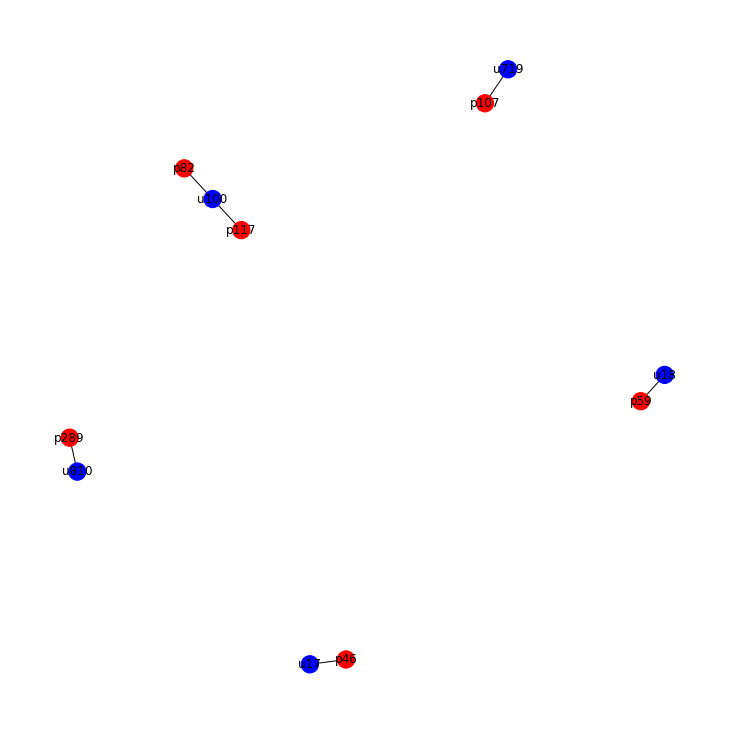

In [84]:
G1=islands[2][1]

plt.figure(figsize=(10,10))
print("Blue for Users | Red for Pages")
colors = ["blue" if i in user_nodes  else "red" for i in G1.nodes]
pos = nx.spring_layout(G1, seed=648)  # Seed layout for reproducible node positions
nx.draw(G1, pos, with_labels=True, node_color=colors)
plt.show()

In [91]:
sorted(G1.degree, key=lambda x: x[1], reverse=True)[0:10]

[('u100', 7),
 ('p117', 5),
 ('p107', 5),
 ('p13', 4),
 ('p59', 3),
 ('p289', 3),
 ('u810', 3),
 ('u3', 2),
 ('u17', 2),
 ('p46', 2)]

In [92]:
#closeness
closeness = nx.closeness_centrality(G1)
sorted(closeness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.2206896551724138),
 ('p117', 0.21333333333333335),
 ('u810', 0.1641025641025641),
 ('p289', 0.16000000000000003),
 ('u346', 0.15609756097560978)]

In [93]:
#betweenness
betweenness = nx.betweenness_centrality(G1)
sorted(betweenness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.0967948717948718),
 ('p117', 0.09358974358974359),
 ('u346', 0.035897435897435895),
 ('p13', 0.025),
 ('p289', 0.02179487179487179)]

In [94]:
#pagerank
pagerank = nx.pagerank(G1)
sorted(pagerank.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.07300994562791337),
 ('p107', 0.06669061402875158),
 ('p117', 0.052464918301483074),
 ('p13', 0.04468251874508064),
 ('p59', 0.03887238475697667)]

Blue for Users | Red for Pages


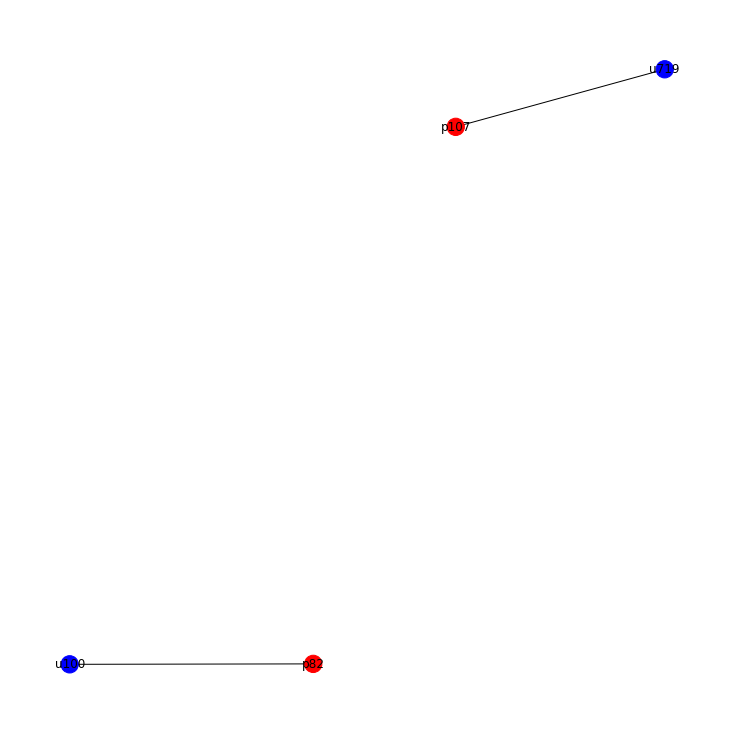

In [83]:
G1=islands[3][1]

plt.figure(figsize=(10,10))
print("Blue for Users | Red for Pages")
colors = ["blue" if i in user_nodes  else "red" for i in G1.nodes]
pos = nx.spring_layout(G1, seed=648)  # Seed layout for reproducible node positions
nx.draw(G1, pos, with_labels=True, node_color=colors)
plt.show()

In [95]:
sorted(G1.degree, key=lambda x: x[1], reverse=True)[0:10]

[('u100', 7),
 ('p117', 5),
 ('p107', 5),
 ('p13', 4),
 ('p59', 3),
 ('p289', 3),
 ('u810', 3),
 ('u3', 2),
 ('u17', 2),
 ('p46', 2)]

In [96]:
#closeness
closeness = nx.closeness_centrality(G1)
sorted(closeness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.2206896551724138),
 ('p117', 0.21333333333333335),
 ('u810', 0.1641025641025641),
 ('p289', 0.16000000000000003),
 ('u346', 0.15609756097560978)]

In [97]:
#betweenness
betweenness = nx.betweenness_centrality(G1)
sorted(betweenness.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.0967948717948718),
 ('p117', 0.09358974358974359),
 ('u346', 0.035897435897435895),
 ('p13', 0.025),
 ('p289', 0.02179487179487179)]

In [98]:
#pagerank
pagerank = nx.pagerank(G1)
sorted(pagerank.items(), key=lambda x: x[1], reverse = True)[:5]

[('u100', 0.07300994562791337),
 ('p107', 0.06669061402875158),
 ('p117', 0.052464918301483074),
 ('p13', 0.04468251874508064),
 ('p59', 0.03887238475697667)]